In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/grid38/bin/python


In [2]:
import numpy as np

import scores

from scipy.signal import find_peaks

from tqdm import tqdm

import os

# viz
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
"""

    where am i?

"""

PATH = os.getcwd()
precomputed_path = PATH + '/precomputed/'

print( f'PATH: { PATH }' )
print( f'precomputed path: { precomputed_path }' )

PATH: /Users/no_lineal/Documents/GitHub/dm-grid-cells
precomputed path: /Users/no_lineal/Documents/GitHub/dm-grid-cells/precomputed/


In [4]:
""" 

    load dataset

"""

res_lst = sorted( [ x for x in os.listdir( precomputed_path + 'res/' ) if '.npy' in x] )
res_lst = [ np.load( precomputed_path + 'res/' + x, allow_pickle=True, encoding='latin1' ) for x in res_lst ]

scores_lst = sorted( [ x for x in os.listdir( precomputed_path + 'scores/' ) if '.npy' in x ] )
scores_lst = [ np.load( precomputed_path + 'scores/' + x, allow_pickle=True, encoding='latin1' ) for x in scores_lst ]

print( f'res_lst: { len(res_lst) }' )
print( f'scores_lst: { len(scores_lst) }' )

res_lst: 1
scores_lst: 1


In [5]:
"""  

    sample

"""

sample_res = np.random.choice( res_lst, 1 )
sample_res = dict( sample_res[0].item() )

sample_res.keys()
print( f'sample lstm: { sample_res["lstm"].shape }' )
print( f'sample bootleneck: { sample_res["bottleneck"].shape }' )
print( f'sample pos_xy: { sample_res["pos_xy"].shape }' )

sample lstm: (4000, 100, 128)
sample bootleneck: (4000, 100, 256)
sample pos_xy: (4000, 100, 2)


In [6]:
""" 

    get scores

"""

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
masks_parameters = zip(starts, ends.tolist())

coord_range = ( (-1.1, 1.1), (-1.1, 1.1) )

latest_epoch_scorer = scores.GridScorer(50, coord_range, masks_parameters)

# concatenate trajectories
xy = sample_res['pos_xy'].reshape(-1, sample_res['pos_xy'].shape[-1])
act = sample_res['bottleneck'].reshape(-1, sample_res['bottleneck'].shape[-1])
n_units = act.shape[1]

# get ratemap for each unit
s = [ latest_epoch_scorer.calculate_ratemap(xy[:, 0], xy[:, 1], act[:, i]) for i in tqdm(range(n_units)) ]

# Get the scores
score_60, score_90, max_60_mask, max_90_mask, sac = zip( * [ latest_epoch_scorer.get_scores(rate_map) for rate_map in tqdm(s) ] )

print( f'xy: { xy.shape }' )
print( f'act: { act.shape }' )
print( f'n_units: { n_units }' )
print('')
print( f'score_60: { len(score_60) }' )
print( f'score_90: { len(score_90) }' )
print( f'max_60_mask: { len(max_60_mask) }' )
print( f'max_90_mask: { len(max_90_mask) }' )
print( f'sac: { len(sac) }' )

100%|██████████| 256/256 [00:49<00:00,  5.22it/s]

xy: (400000, 2)
act: (400000, 256)
n_units: 256

score_60: 256
score_90: 256
max_60_mask: 256
max_90_mask: 256
sac: 256


In [7]:
""" 

    find peaks

"""

def find_grid_scales( sac ):

    grid_scales = []

    for s in tqdm(sac):

        s = s.flatten()
        peaks, _ = find_peaks( s )

        grid_scales.append( peaks )

    return grid_scales

    #    distances = np.diff( peaks )

    #    if len( distances ) > 1:

    #        grid_scale = np.mean( distances )
    #        grid_scales.append( grid_scale )

    #    else:

    #        grid_scales.append( 0 )

    #return np.array( grid_scales )

sac = np.array( sac )
grid_scales = find_grid_scales( sac )

#print( f'grid_scales: { grid_scales.shape }' )
print( f'len grid scales: { len(grid_scales) }' )

100%|██████████| 256/256 [00:00<00:00, 14090.55it/s]

len grid scales: 256


idx_sample: 45
sac_sample: (99, 99)
grid_scales_sample: (461,)
peaks_2d_sample: 2


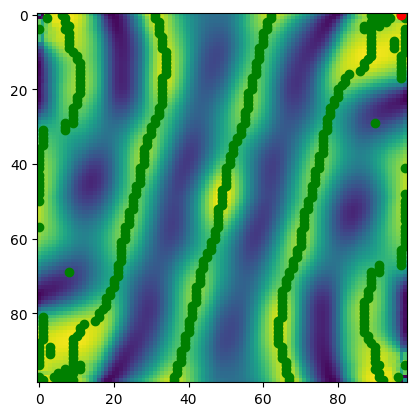

In [29]:
"""  

    sac sample

"""

idx_sample = np.random.choice( range(len(sac)) )
sac_sample = sac[ idx_sample ]
peaks_sample = grid_scales[ idx_sample ]

peaks_2d_sample = np.unravel_index( peaks_sample, sac_sample.shape  )
max_peak_sample = np.unravel_index( np.argmax( sac_sample ), sac_sample.shape)

print( f'idx_sample: { idx_sample }' )
print( f'sac_sample: { sac_sample.shape }' )
print( f'grid_scales_sample: { peaks_sample.shape }' )
print( f'peaks_2d_sample: { len(peaks_2d_sample) }' )

plt.imshow( sac_sample )
plt.plot( peaks_2d_sample[1], peaks_2d_sample[0], 'go' )
plt.plot( max_peak_sample[1], max_peak_sample[0], 'ro' )
plt.show()